In [2]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt

In [3]:
#Import the consolidated data set
file_path = "data\\3_intermediate\\int_texas_border_report.csv"

border_report = pd.read_csv(
    file_path, 
    parse_dates=['nibrs_start_date', 'report_year'], 
    date_format='%Y-%m-%d')

border_report.head()

,agency_name,county,population,nibrs_start_date,murder_and_nonnegligent_manslaughter,negligent_manslaughter,rape,robbery,assault,burglary,...,arson,human_trafficking_commercial_sex_acts,human_trafficking_involuntary_servitude,months_reported,report_year,agency_type,university_pd,nibrs_eligible_months,has_preliminary_nibrs_reporting,nibrs_contribution_percentage
0,ALAMO PD,Hidalgo County,19351,2018-08-01,0,0,0,0,0,0,...,0,0,0,0,2017-12-31,Police Department,False,0,False,0.00
1,ALPINE PD,Brewster County,5983,2020-04-01,0,0,0,0,0,0,...,0,0,0,0,2017-12-31,Police Department,False,0,False,0.00
2,ALTON PD,Hidalgo County,17432,2019-09-01,0,0,0,0,0,0,...,0,0,0,0,2017-12-31,Police Department,False,0,False,0.00
3,ANTHONY PD,El Paso County,5681,2020-12-01,0,0,0,0,0,0,...,0,0,0,0,2017-12-31,Police Department,False,0,False,0.00
4,BREWSTER CO SO,Brewster County,3196,2015-01-01,1,0,2,0,19,4,...,1,0,0,11,2017-12-31,Sheriff's Office,False,12,False,91.67


In [4]:
print("There are", border_report['agency_name'].nunique(),"agencies in the border report covering", border_report['county'].nunique(),"counties.")

There are 85 agencies in the border report covering 14 counties.


In [5]:
lea_per_county = border_report[['county','agency_name','agency_type','university_pd']].drop_duplicates()
lea_per_county.to_csv('data\\4_fact\\lea_per_county.csv', index=False)

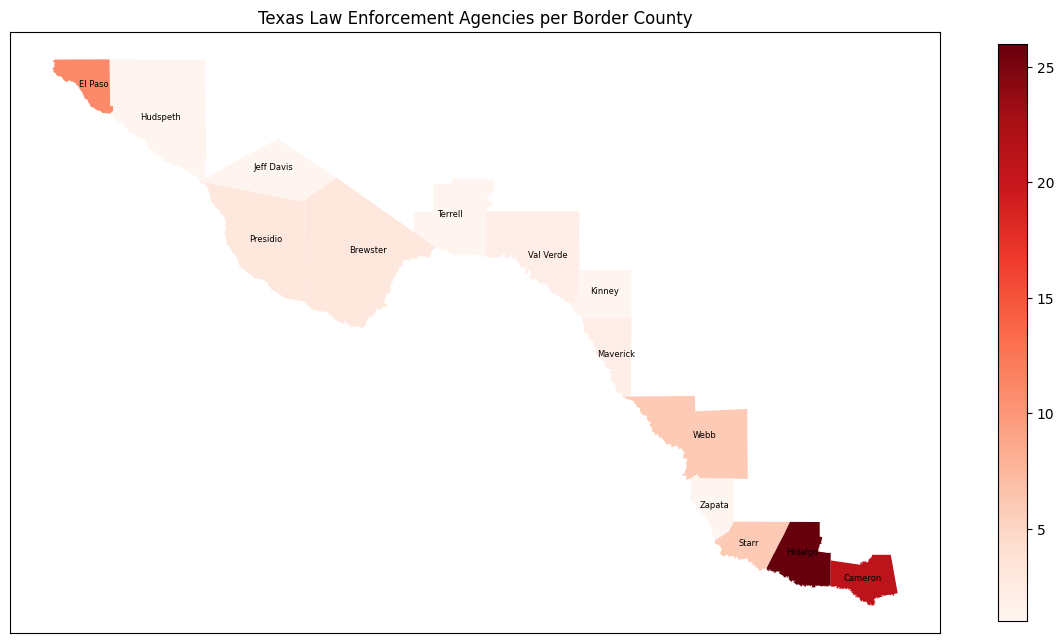

In [20]:
# Load the law enforcement agencies data
data_path = 'data\\4_fact\\lea_per_county.csv'
data = pd.read_csv(data_path)

# Aggregate the data by county to count the number of law enforcement agencies per county
agency_count_per_county = data.groupby('county').size().reset_index(name='agency_count')
agency_count_per_county['county_name'] = agency_count_per_county['county'].str.replace(' County', '')

# Load the Texas county data
texas_county_data_path = 'data\\1_raw\\texas_county_shapes.csv'
texas_county_data = pd.read_csv(texas_county_data_path)

# Convert the 'the_geom' column to a geometry type and rename for merging
texas_county_data['geometry'] = texas_county_data['the_geom'].apply(wkt.loads)
geo_texas_county_data = gpd.GeoDataFrame(texas_county_data, geometry='geometry')
geo_texas_county_data = geo_texas_county_data.rename(columns={'NAME': 'county_name'})

# Merge the datasets on the county names
merged_data = pd.merge(geo_texas_county_data, agency_count_per_county, left_on='county_name', right_on='county_name', how='left')

# Convert the merged dataframe to a GeoDataFrame and fill NaN values
merged_geo_data = gpd.GeoDataFrame(merged_data, geometry='geometry')
merged_geo_data['agency_count'] = merged_geo_data['agency_count'].fillna(0)

# Filter the GeoDataFrame to only include counties with law enforcement agencies
filtered_geo_data = merged_geo_data[merged_geo_data['agency_count'] > 0]

# Plotting the map with the red color scale for counties with law enforcement agencies
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
filtered_geo_data.plot(column='agency_count', ax=ax, legend=True,
                       cmap='Reds',
                       legend_kwds={
                            'orientation': 'vertical',
                            'shrink': 0.5
                                    })

# Annotate county names
for idx, row in filtered_geo_data.iterrows():
    # Use representative point to avoid placing text outside the polygons
    repr_point = row['geometry'].representative_point().coords[:]
    ax.text(repr_point[0][0], repr_point[0][1], row['county_name'], fontsize=6, ha='center')

# # Position the legend inside the map area at the lower left corner
# leg = ax.get_legend()
# leg.set_bbox_to_anchor((0.0, 0.0))
# leg.set_loc('uppere right')

# Hide the latitude and longitude coordinates on the axes
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])


plt.title('Texas Law Enforcement Agencies per Border County')
plt.show()